# Learning Laplacian eigenfunctions in three dimensions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load libraries
import logging

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

from klap import (
    ExponentialKernel,
    GaussianKernel,
    PolynomialKernel,
)
from klap.datasets.helper import (
    meshgrid_3d,
    plot_sphere_surface,
    spherical_harmonic,
)
from klap.datasets import swissroll

# Set logger
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
)

#### Generate data 

In [3]:
np.random.seed(100)
n = 1000
p = 500

x, t_train = swissroll(n, noise_level=.0, verbose=True)
x_test, t_test = swissroll(100, noise_level=0, verbose=True, train=False)

(-10.573687313649277, 13.703176984655558, -1.0, 21.0)

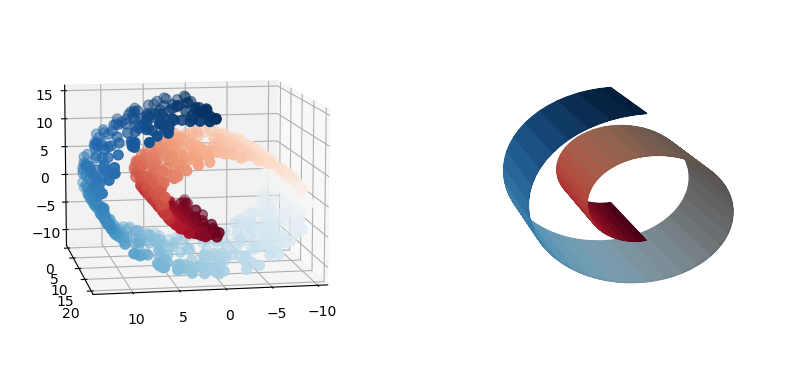

In [4]:
vmin, vmax = t_test.min(), t_test.max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 5))
ax1.scatter(x[:,0], x[:,1], x[:, 2], s=50, c=t_train, vmin=vmin, vmax=vmax, cmap='RdBu')
ax1.view_init(azim=80, elev=10)
# ax1.axis('off')

ax2.plot_surface(x_test[...,0], x_test[...,1], x_test[..., 2], facecolors=plt.get_cmap("RdBu")(norm(t_test)))
ax2.view_init(azim=80, elev=10)
ax2.axis('off')

#### Choose a kernel and method

In [5]:
# kernel = PolynomialKernel(d=2)
# kernel = ExponentialKernel(sigma=50)
kernel = GaussianKernel(sigma=10)

graph_laplacian = False

#### Fit eigenfunctions

In [6]:
help(kernel.fit)

Help on method fit in module klap.kernels.kernel_laplacian:

fit(x, p=None, k=None, L_reg: float = 0, R_reg: float = 0, inverse_L: bool = False) method of klap.kernels.gaussian_fast.GaussianKernel instance
    Estimate Laplacian operator based on data.
    
    Parameters
    ----------
    x: ndarray of size (n, d)
        Data matrix
    p: int (optional, default is None)
        Number of representer points to use
    k: int (optional, default is None)
        Number of eigenvalues to compute. If None, k will be taken as self.k (default is 16)
    L_reg: float (optional, default is 0)
        Regularization parameter for Laplacian matrix
    R_reg: float (optional, default is 0)
        Regularization parameter for Nystrom matrix
    inverse_L: bool (optional, default is False)
        Either to inverse L or R in the GEVD system.



In [7]:
k = 16
L_reg = 0
R_reg = 0
inverse_L = True

if graph_laplacian:
    weigth_kernel = GaussianKernel(sigma=1).kernel
    kernel.fit_with_graph_laplacian(weigth_kernel, x, p=p, k=k, L_reg=L_reg, R_reg=R_reg, inverse_L=inverse_L)
else:
    kernel.fit(x, p=p, k=k, L_reg=L_reg, R_reg=R_reg, inverse_L=inverse_L)

2023-05-04 22:00:05,564 INFO Inversing L
2023-05-04 22:00:05,571 INFO Matrix is not sdp.
2023-05-04 22:00:05,571 INFO Setting regularizer to 2.906e-16


#### Get eigenfunctions / features map

In [8]:
phi = kernel(x_test.reshape(-1, 3)).reshape(*x_test.shape[:2], -1)

#### Plot eigenfunctions

In [9]:
num = 4

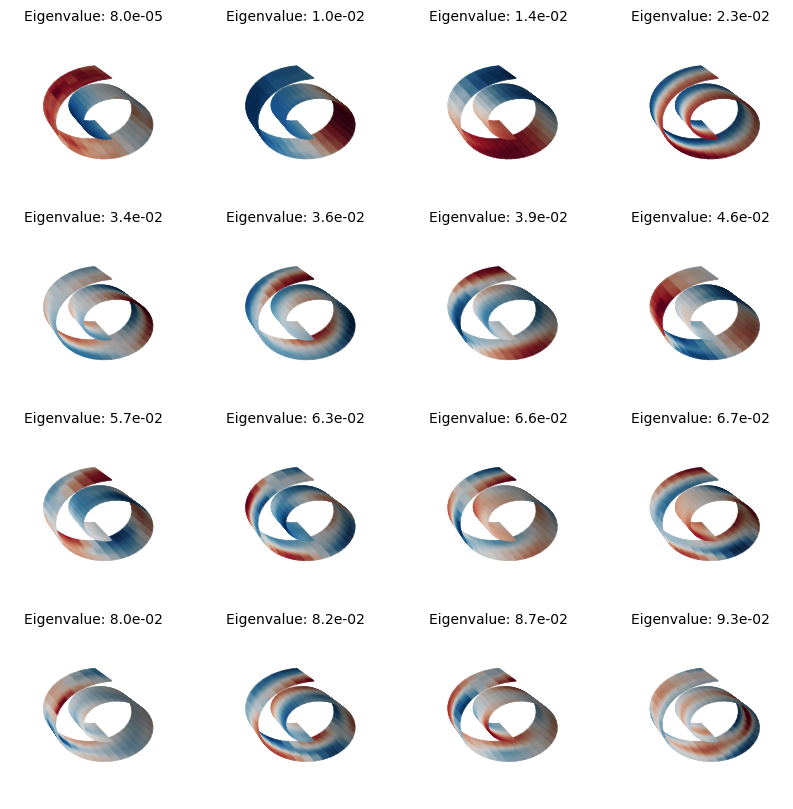

In [10]:
X, Y, Z = x_test[..., 0], x_test[..., 1], x_test[..., 2]
fig, axes = plt.subplots(num, num, figsize=(10, 10), subplot_kw={"projection": "3d"})
norm = colors.Normalize(vmin=phi.min(), vmax=phi.max())
for i in range(num ** 2):
    phi_i = phi[..., i]
    norm = colors.Normalize(vmin=phi_i.min(), vmax=phi_i.max())
    cm = plt.get_cmap("RdBu")(norm(phi_i))
    axes[i//num, i%num].plot_surface(X, Y, Z, facecolors=cm, alpha=.5)
    axes[i//num, i%num].set_title(f"Eigenvalue: {kernel.eigenvalues[i]:.1e}", fontsize=10)
    axes[i//num, i%num].view_init(azim=80, elev=10)
    axes[i//num, i%num].axis('off')

#### Unrolling the swiss roll

In [11]:
kernel = PolynomialKernel(d=1)
kernel.fit(x, p=p, k=k, L_reg=L_reg, R_reg=R_reg, inverse_L=inverse_L)
phi = kernel(x_test.reshape(-1, 3)).reshape(*x_test.shape[:2], -1)

2023-05-04 22:00:08,363 INFO Dot product kernel computation
2023-05-04 22:00:08,372 INFO Inversing L
2023-05-04 22:00:08,379 INFO Matrix is not sdp.
2023-05-04 22:00:08,393 INFO Setting regularizer to 1.015e-10


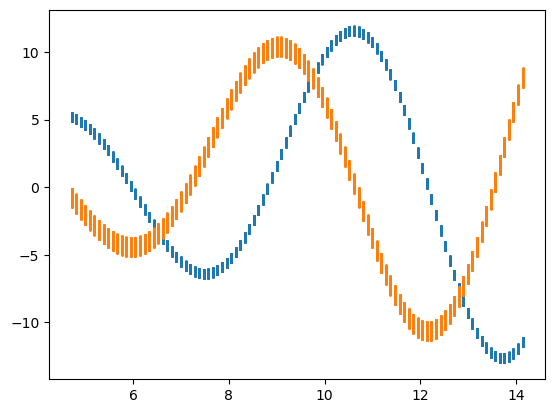

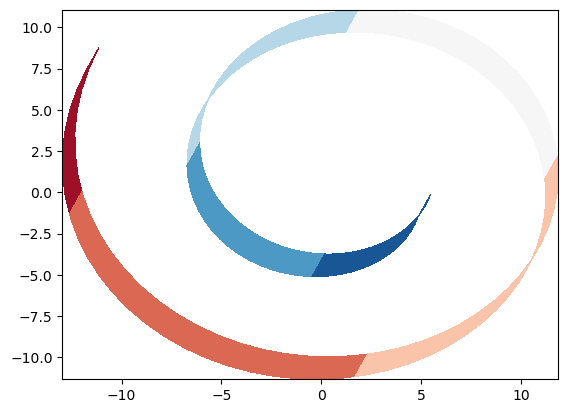

In [12]:
phi_1, phi_2, phi_3 = phi[..., 0], phi[..., 1], phi[..., 2]
x1, x2 = t_test, x_test[..., 1]
# plt.figure()
# plt.contourf(x1, x2, phi_1, cmap="RdBu_r")
# plt.figure()
# plt.contourf(x1, x2, phi_2, cmap="RdBu_r")
plt.figure()
plt.scatter(t_test, phi_2, s=1)
plt.scatter(t_test, phi_3, s=1)
# plt.figure()
# plt.contourf(phi_1, phi_2, t_test, cmap="RdBu_r")
plt.figure()
plt.contourf(phi_2, phi_3, t_test, cmap="RdBu_r")